## Code to check post-transpilation depth of strongly entangling layers and input embedding layers

In [157]:
# ALL IMPORTS
import pennylane as qml
from pennylane import numpy as np
import pennylane_qiskit as pq
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.utils.data as Data
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
# from qiskit.providers.fake_provider import FakeGuadalupeV2, FakeTokyo, FakeMumbaiV2, FakePrague, FakeBrooklynV2, FakeWashingtonV2, FakeManhattan 
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from qiskit import QuantumCircuit
# from qiskit.providers.fake_provider import FakeKolkataV2, FakeMumbaiV2, FakeWashington, FakeMumbai
# from qiskit.providers.fake_provider.fake_backend import FakeBackendV2
from qiskit.providers.fake_provider import Fake127QPulseV1, Fake27QPulseV1, Fake5QV1, Fake20QV1, Fake7QPulseV1, GenericBackendV2
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library import (
    IGate, CXGate, RZGate, SXGate,
    XGate, U1Gate, U2Gate, U3Gate,
    Reset, Measure, CZGate
)
from qiskit.circuit import Delay
from qiskit_algorithms.optimizers import SPSA, COBYLA
from qiskit.primitives import Sampler, BackendSampler
from qiskit_aer import AerSimulator
import qiskit_aer.noise as noise
from qiskit_aer.noise import NoiseModel
import time
from matplotlib import pyplot as plt
from IPython.display import clear_output
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit import transpile
from qiskit.transpiler import CouplingMap
from sklearn.svm import SVC
from datetime import datetime
from qiskit.converters import circuit_to_dag, dag_to_circuit
from collections import OrderedDict
from tqdm import tqdm
import json
import inspect
from utils import *
from functools import partial

In [158]:
# DEFINE ALL NEEDED VARIABLES

# Define fixed attributes
num_layers = 6
batch_size = 16

# Load iris dataset
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target
######################################

# Load the digits dataset
digits_data = load_digits()
features = digits_data.data
labels = digits_data.target

# Specify the target labels
target_labels = [0,1]
label_mapping = {}
cnt = 0
for label in target_labels:
    label_mapping[label] = cnt
    cnt+=1

# Filter the dataset for the desired digits
filtered_indices = np.isin(labels, target_labels)
features_filtered = features[filtered_indices]
labels_filtered = labels[filtered_indices]

# Initialize empty arrays for the limited features and labels
features_limited = np.empty((0, features_filtered.shape[1]))
labels_limited = np.array([])

# Limit to 50 images per specified class
for digit in target_labels:
    digit_indices = np.where(labels_filtered == digit)[0][:]  # Get the first 100 indices for each digit
    features_limited = np.vstack((features_limited, features_filtered[digit_indices]))
    digit_labels = labels_filtered[digit_indices]
    mapped_labels = np.array([label_mapping[label] for label in digit_labels])
    labels_limited = np.concatenate((labels_limited, mapped_labels))

features = features_limited
labels = labels_limited
#######################################

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.4, random_state=42)
X_train, X_test, y_train, y_test = torch.from_numpy(X_train).float(), torch.from_numpy(X_test).float(), torch.from_numpy(y_train), torch.from_numpy(y_test)
train_dataset = Data.TensorDataset(X_train, y_train)
test_dataset = Data.TensorDataset(X_test, y_test)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)

# Define the quantum device
device = 'cpu'

In [159]:
# ALL QUBIT LAYOUTS

# 8 QUBIT LAYOUTS
#*****************************************************************
'''27 qubit h/w layouts'''
# layout_qubits = [4,7,10,12,15,18,20,23] 
# layout_coupling = [[4,7],[7,10],[10,12],[12,15],[15,18],[18,20],[20,23]]
# backend = Fake27QPulseV1()

# layout_qubits = [4,7,10,12,13,15,18,20] 
# layout_coupling = [[4,7],[7,10],[10,12],[12,15],[15,18],[18,20],[12,13]]
# backend = Fake27QPulseV1()

# layout_qubits = [7,10,12,15,18,20,13,14] 
# layout_coupling = [[7,10],[10,12],[12,15],[15,18],[18,20],[12,13],[13,14]]
# backend = Fake27QPulseV1()

# layout_qubits = [10,12,15,18,20,23,24,13] 
# layout_coupling = [[10,12],[12,15],[15,18],[18,20],[20,23],[23,24],[12,13]]
# backend = Fake27QPulseV1()

# layout_qubits = [4,7,10,12,15,18,6,13] 
# layout_coupling = [[4,7],[7,10],[10,12],[12,15],[15,18],[6,7],[12,13]]
# backend = Fake27QPulseV1()

'''127 qubit h/w layouts'''
# layout_qubits = [14,18,19,20,21,22,23,24]
# layout_coupling = [[14,18],[18,19],[19,20],[20,21],[21,22],[22,23],[23,24]]
# backend = Fake127QPulseV1()

# layout_qubits = [19,20,21,22,23,24,25,15]
# layout_coupling = [[19,20],[20,21],[21,22],[22,23],[23,24],[24,25],[22,15]]
# backend = Fake127QPulseV1()

layout_qubits = [20,21,22,23,24,25,15,4]
layout_coupling = [[20,21],[21,22],[22,23],[23,24],[24,25],[22,15],[15,4]]
backend = Fake127QPulseV1()

# layout_qubits = [14,18,19,20,21,22,23,15]
# layout_coupling = [[14,18],[18,19],[19,20],[20,21],[21,22],[22,23],[22,15]]
# backend = Fake127QPulseV1()

# layout_qubits = [19,20,21,22,23,24,15,33]
# layout_coupling = [[19,20],[20,21],[21,22],[22,23],[23,24],[20,33],[22,15]]
# backend = Fake127QPulseV1()

'''20 qubit h/w layouts'''
# layout_qubits = [0,1,6,5,10,11,15,16]
# layout_coupling = [[0,1],[1,6],[6,5],[5,10],[10,11],[11,16],[16,15]]
# backend = Fake20QV1()

# layout_qubits = [5,6,7,8,9,14,13,3]
# layout_coupling = [[5,6],[6,7],[7,8],[8,9],[9,14],[14,13],[8,3]]
# backend = Fake20QV1()

# layout_qubits = [6,7,8,9,14,13,3,2]
# layout_coupling = [[6,7],[7,8],[8,9],[9,14],[14,13],[8,3],[3,2]]
# backend = Fake20QV1()

# layout_qubits = [0,1,2,3,8,9,14,6]
# layout_coupling = [[0,1],[1,2],[2,3],[3,8],[8,9],[9,14],[1,6]]
# backend = Fake20QV1()

# layout_qubits = [5,6,1,2,3,4,0,8]
# layout_coupling = [[5,6],[6,1],[1,2],[2,3],[3,4],[1,0],[3,8]]
# backend = Fake20QV1()

#*****************************************************************

'20 qubit h/w layouts'

In [160]:
# DEFINE PQC 

num_qubits = len(layout_qubits)

# Create the subset backend
noise_model_partial, custom_backend = create_subset_backend(layout_qubits, layout_coupling, backend)
new_lq, new_lc = qubit_numbering_mapping(layout_qubits, layout_coupling)

dev = qml.device('qiskit.aer', wires=num_qubits, backend=custom_backend, initial_layout=new_lq)
# dev = pq.AerDevice(wires=num_qubits, compile_backend=custom_backend)
# dev = qml.device('qiskit.aer', wires=num_qubits, backend=Fake5QV1()) #52.16% test mean

# Define the PQC circuit
# @qml.qnode(dev)
@qml.qnode(dev, interface='torch')
def pqc_iris_strong(inputs, params):
    # qml.templates.AngleEmbedding(inputs, wires=range(num_qubits))
    qml.templates.StronglyEntanglingLayers(params, wires=range(num_qubits), ranges=[1,1,1,1,1,1])
    # return np.array([qml.expval(qml.PauliZ(i)) for i in range(3)]) FOR PURELY PENNYLANE
    return [qml.expval(qml.PauliZ(i)) for i in range(3)]

@qml.qnode(dev, interface='torch')
# def pqc_digits_strong(inputs, params):
def pqc_digits_strong(inputs, params):
    # qml.templates.AngleEmbedding(inputs, wires=range(num_qubits))
    # qml.templates.AmplitudeEmbedding(inputs, wires=range(6), normalize=True)
    qml.templates.StronglyEntanglingLayers(params, wires=range(num_qubits), ranges=[1])
    return [qml.expval(qml.PauliZ(i)) for i in range(8)]

66.86


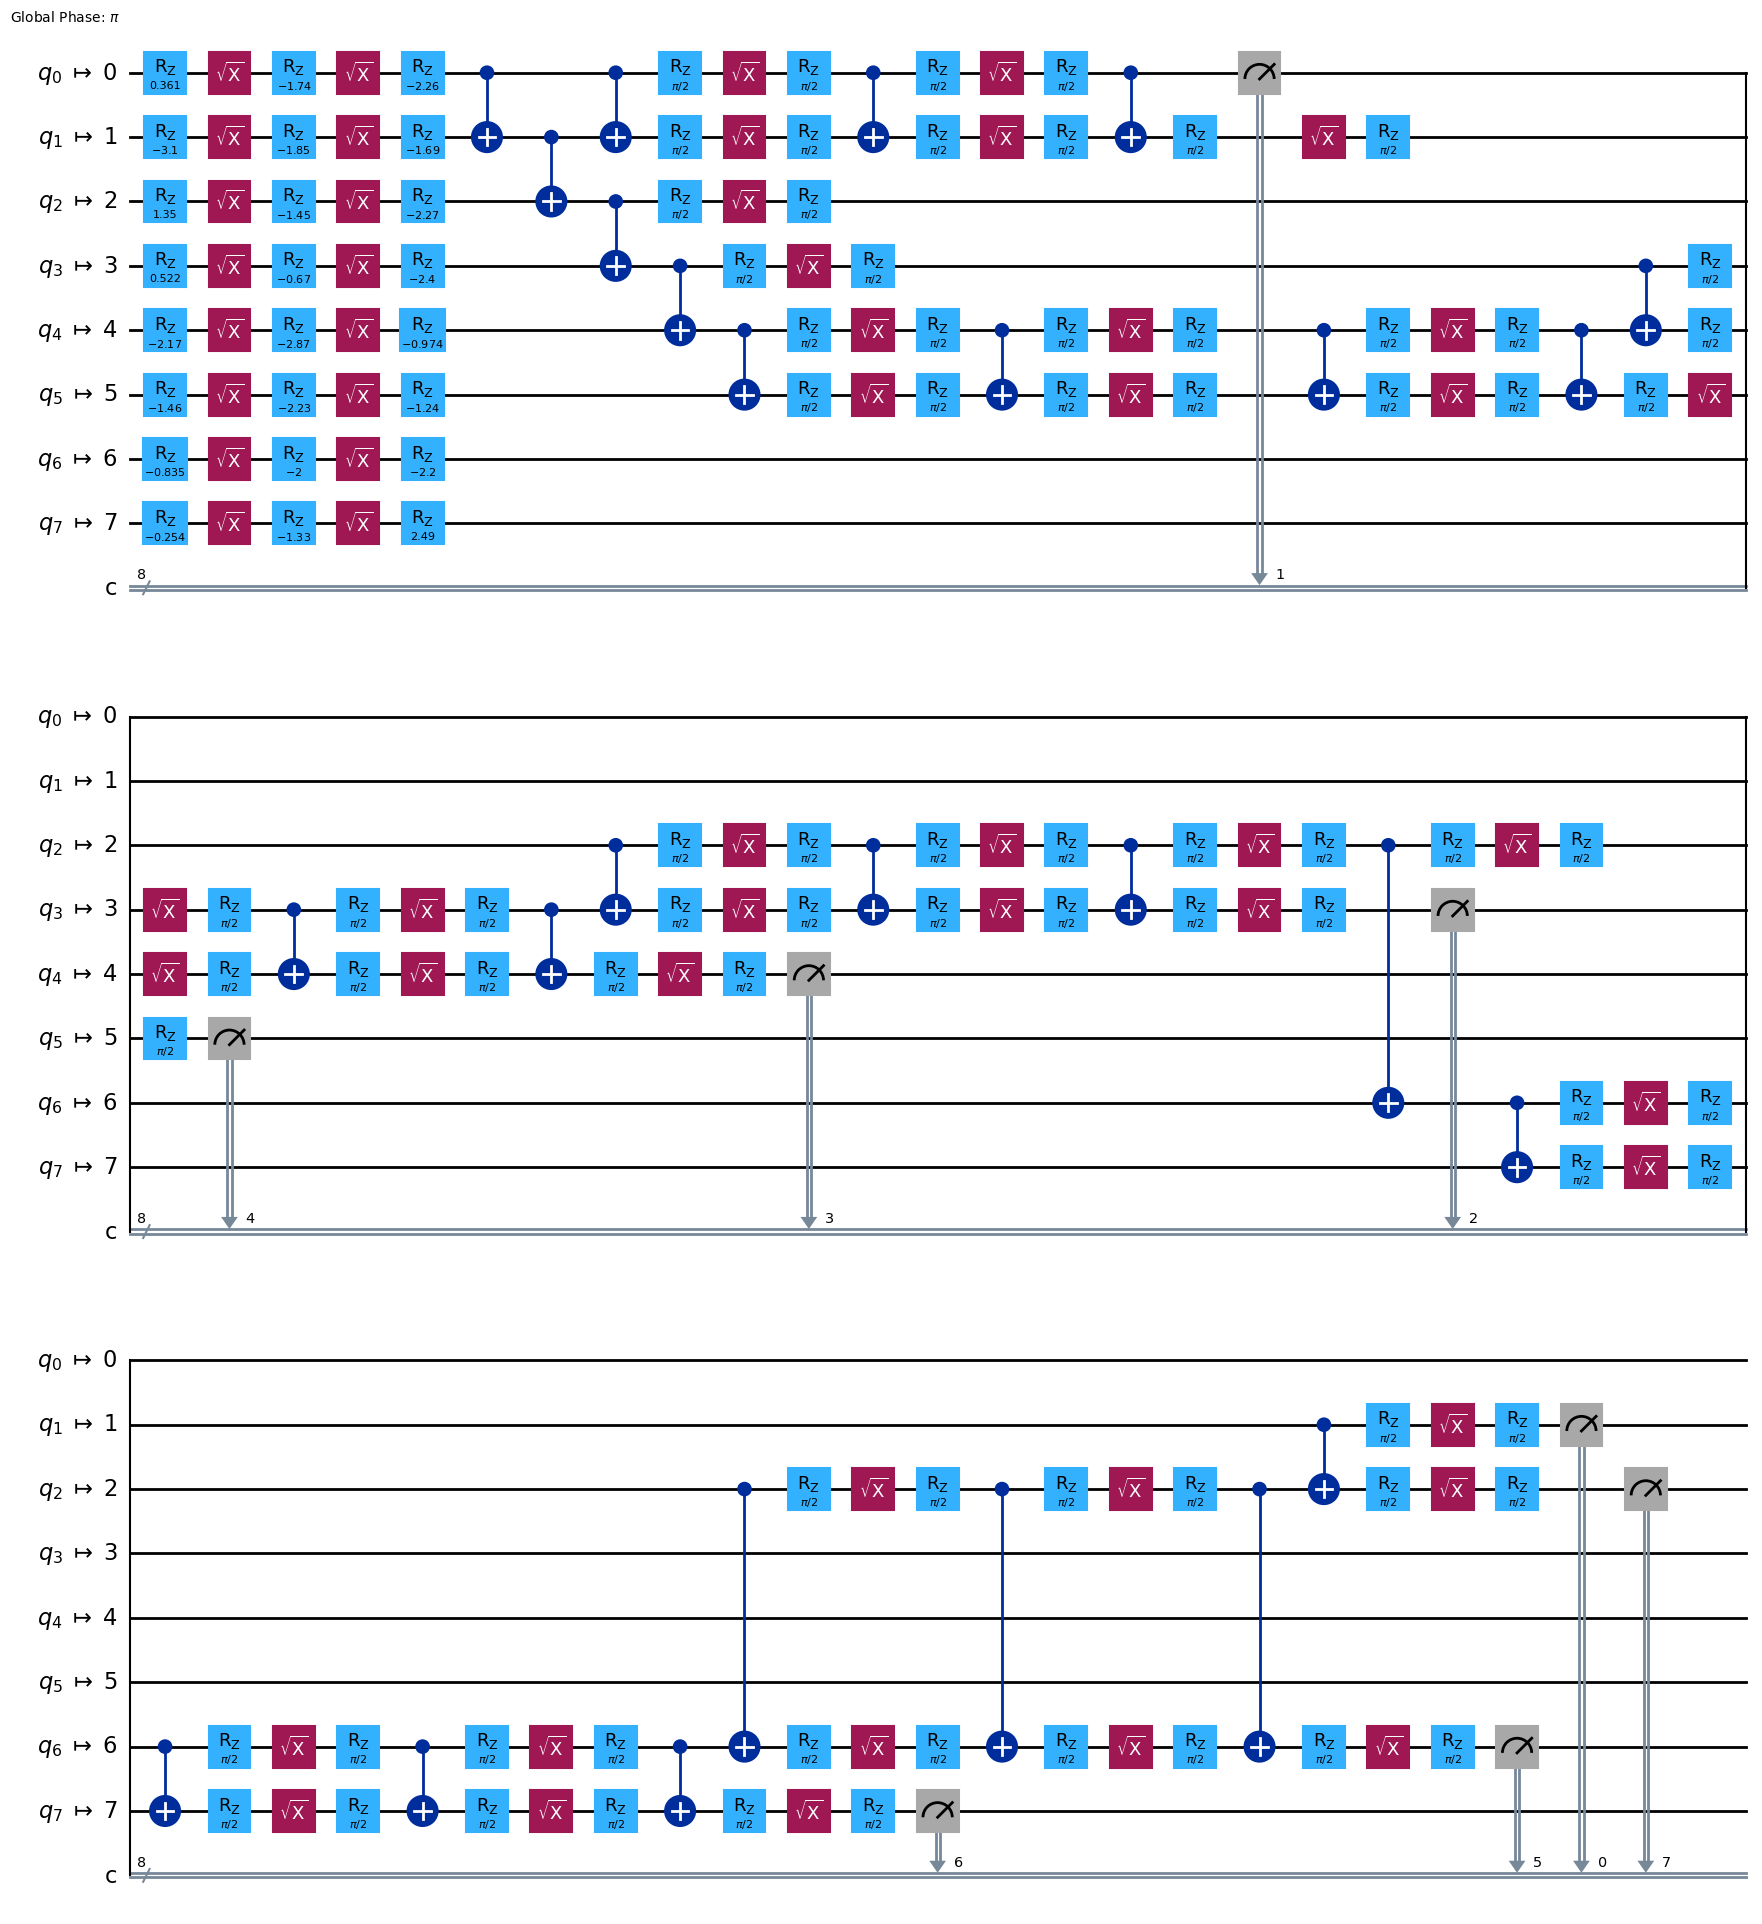

In [161]:
# params = torch.load('strongly_entangling_layers_iris_27hw_range2_8q.pth')
torch.manual_seed(61)
# pqc_iris_strong.construct([0.5, params['qlayer.params'].tolist()], {})
pqc_digits_strong.construct([features[0], torch.randn(1,8,3).tolist()], {})
t = pqc_digits_strong.qtape.to_openqasm()
# pqc_iris_strong.construct([0.5, torch.randn(6,8,3).tolist()], {})
# t = pqc_iris_strong.qtape.to_openqasm()

qc = QuantumCircuit.from_qasm_str(t)

new_lq, new_lc = qubit_numbering_mapping(layout_qubits, layout_coupling)
depth_list = []
for i in range(50):
    qc_transpiled = transpile(qc, backend=custom_backend, coupling_map=custom_backend.configuration().coupling_map, optimization_level=1, initial_layout=new_lq)
    depth_list.append(qc_transpiled.depth())
print(sum(depth_list)/len(depth_list))
qc_transpiled.draw(output='mpl')

In [162]:
print(custom_backend.configuration().coupling_map)

[[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [2, 6], [6, 7]]
